In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
# timesteps from 1h to 24h 
df = pd.read_csv("cleaned_data\\24timestep1h.csv", parse_dates=['tstp'])
df = df.drop(['date'], axis=1) # date column when joined with the holiday

In [4]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(df[['Type']])
summary_labels = summary_encoder.fit_transform(df[['summary']])
household_labels = household_encoder.fit_transform(df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
# process fourier features for each group and saved each group's deterministic process
import math

dps = {}

all_household_ids = encoded_df['household_label'].unique()
households_grp = encoded_df.groupby('household_label')
training_df = []
testing_df = []

for household_id in all_household_ids:
    # get the household from the entire df
    print("Household id:", household_id)
    singlehousehold_df = households_grp.get_group(household_id).sort_values(by='tstp', ascending=True)

    # split into train, test
    cutoff_point = math.floor(singlehousehold_df.shape[0] * 0.9)
    training_singlehousehold_df = singlehousehold_df.iloc[:cutoff_point].reset_index()
    testing_singlehousehold_df = singlehousehold_df.iloc[cutoff_point:].reset_index()

    # create fourier features
    fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
    fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
    training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
    fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
    testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)
    
    # save the dp object
    dps[household_id] = fourier_obj

    # append to the household_dfs list
    training_df.append(training_singlehousehold_df)
    testing_df.append(testing_singlehousehold_df)

training_df = pd.concat(training_df, axis=0)
testing_df = pd.concat(testing_df, axis=0)

Household id: 35
Household id: 30
Household id: 14
Household id: 46
Household id: 41
Household id: 24
Household id: 26
Household id: 37
Household id: 6
Household id: 45
Household id: 19
Household id: 3
Household id: 39
Household id: 32
Household id: 8
Household id: 22
Household id: 11
Household id: 38
Household id: 42
Household id: 10
Household id: 15
Household id: 16
Household id: 29
Household id: 36
Household id: 1
Household id: 23
Household id: 31
Household id: 28
Household id: 21
Household id: 7
Household id: 49
Household id: 17
Household id: 27
Household id: 0
Household id: 44
Household id: 5
Household id: 40
Household id: 12
Household id: 48
Household id: 33
Household id: 13
Household id: 2
Household id: 50
Household id: 43
Household id: 25
Household id: 34
Household id: 20
Household id: 18
Household id: 4
Household id: 9
Household id: 47


In [7]:
# scale the values
from sklearn.preprocessing import MinMaxScaler

# drop unnecessary columns
training_df = training_df.drop(['index', 'tstp'], axis=1)
testing_df = testing_df.drop(['level_0', 'tstp'], axis=1)

# separate into features and target
X_train = training_df.drop(['energy(kWh/hh)'], axis=1)
X_test = testing_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_df['energy(kWh/hh)']
y_test = testing_df['energy(kWh/hh)']

# store the household ids for future evaluation
test_household_ids = X_test['household_label']
train_household_ids = X_train['household_label']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape for LSTM, CNN-LSTM models
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_test.shape)

(686587, 1, 134)
(76315, 1, 134)


In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[2]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test, deep_learning):
  """
    Evaluate the model predictions with all the regression metrics
  """
  if deep_learning:
    prediction = y_pred.ravel()

  else:
    prediction = y_pred

  print("RMSE:", mean_squared_error(prediction, y_test, squared=False))
  print("MSE:", mean_squared_error(prediction, y_test, squared=True))
  print("MAE:", mean_absolute_error(prediction, y_test))
  print("MAPE:", mean_absolute_percentage_error(prediction, y_test))
  print("R2 Score:", r2_score(prediction, y_test))
  print("Adjusted R2 Score:", adjusted_r2(prediction, y_test))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.reshape(-1)[start_idx:end_idx]
        mape_score = mean_absolute_percentage_error(sampled_test, sampled_pred)
        
        sns.lineplot(x=timesteps, y=y_test.iloc[start_idx:end_idx], label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=y_pred.reshape(-1)[start_idx:end_idx], label="pred-value", marker='o', ax=axes[i])
        axes[i].set_title(f'MAPE: {round(mape_score, 2)}')

    plt.tight_layout()
    plt.show()
    

### CNN-LSTM

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, TimeDistributed, Conv1D, Dropout, Input
)

# for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True)

input_layer = Input(shape=(1, X_train.shape[2]))
layer = Conv1D(200, kernel_size=1)(input_layer)
layer = LSTM(300, return_sequences=True)(layer)
layer = LSTM(300, return_sequences=True)(layer)
layer = Dropout(0.2)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer = TimeDistributed(Dense(1))(layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae', 'mse', 'mape']
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=504,
    callbacks=[earlystop]
)

Epoch 1/50
1363/1363 [==============================] - 14s 9ms/step - loss: 1.0268 - mae: 0.2070 - mse: 0.1373 - mape: 1427241.0000 - val_loss: 0.2185 - val_mae: 0.2014 - val_mse: 0.1395 - val_mape: 826492.7500
Epoch 2/50
1363/1363 [==============================] - 12s 8ms/step - loss: 0.1830 - mae: 0.1871 - mse: 0.1131 - mape: 1152671.1250 - val_loss: 0.1953 - val_mae: 0.1894 - val_mse: 0.1272 - val_mape: 738800.1875
Epoch 3/50
1363/1363 [==============================] - 12s 8ms/step - loss: 0.1751 - mae: 0.1808 - mse: 0.1079 - mape: 1036555.4375 - val_loss: 0.1853 - val_mae: 0.1839 - val_mse: 0.1184 - val_mape: 780819.7500
Epoch 4/50
1363/1363 [==============================] - 11s 8ms/step - loss: 0.1707 - mae: 0.1780 - mse: 0.1050 - mape: 989063.8750 - val_loss: 0.1871 - val_mae: 0.1861 - val_mse: 0.1250 - val_mape: 615701.5625
Epoch 5/50
1363/1363 [==============================] - 11s 8ms/step - loss: 0.1675 - mae: 0.1756 - mse: 0.1030 - mape: 948827.6875 - val_loss: 0.1821 - 

In [14]:
# export the model

model.save("models\\cnn_lstm_model.h5")

### Quantile-LSTM

In [15]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss

def plot_training_metrics(history):
  """
    Function to plot the training metrics of the deep learning models
  """
  training_metrics = history.history
  loss = training_metrics['loss']
  val_loss = training_metrics['val_loss']
  loss_10 = training_metrics['output_10_loss']
  val_loss_10 = training_metrics['val_output_10_loss']
  loss_30 = training_metrics['output_30_loss']
  val_loss_30 = training_metrics['val_output_30_loss']
  loss_50 = training_metrics['output_50_loss']
  val_loss_50 = training_metrics['val_output_50_loss']
  loss_70 = training_metrics['output_70_loss']
  val_loss_70 = training_metrics['val_output_70_loss']
  loss_90 = training_metrics['output_90_loss']
  val_loss_90 = training_metrics['val_output_90_loss']


  timesteps = np.arange(len(loss))
  fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 12))

  sns.lineplot(x=timesteps, y=loss, label='loss', marker='o', ax=axes[0][0])
  sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o', ax=axes[0][0])
  axes[0][0].set_title("Loss vs Validation Loss")
  axes[0][0].set_xlabel("Epochs")  
  axes[0][0].set_ylabel("Overall Loss")

  sns.lineplot(x=timesteps, y=loss_10, label='loss_10', marker='o', ax=axes[0][1])
  sns.lineplot(x=timesteps, y=val_loss_10, label='val_loss_10', marker='o', ax=axes[0][1])
  axes[0][1].set_title("Loss vs Validation Loss; alpha=0.1")
  axes[0][1].set_xlabel("Epochs")  
  axes[0][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_30, label='loss_30', marker='o', ax=axes[0][2])
  sns.lineplot(x=timesteps, y=val_loss_30, label='val_loss_30', marker='o', ax=axes[0][2])
  axes[0][2].set_title("Loss vs Validation Loss; alpha=0.3")
  axes[0][2].set_xlabel("Epochs")  
  axes[0][2].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_50, label='loss_50', marker='o', ax=axes[1][0])
  sns.lineplot(x=timesteps, y=val_loss_50, label='val_loss_50', marker='o', ax=axes[1][0])
  axes[1][0].set_title("Loss vs Validation Loss; alpha=0.5")
  axes[1][0].set_xlabel("Epochs")  
  axes[1][0].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_70, label='loss_70', marker='o', ax=axes[1][1])
  sns.lineplot(x=timesteps, y=val_loss_70, label='val_loss_70', marker='o', ax=axes[1][1])
  axes[1][1].set_title("Loss vs Validation Loss; alpha=0.7")
  axes[1][1].set_xlabel("Epochs")  
  axes[1][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_90, label='loss_90', marker='o', ax=axes[1][2])
  sns.lineplot(x=timesteps, y=val_loss_90, label='val_loss_90', marker='o', ax=axes[1][2])
  axes[1][2].set_title("Loss vs Validation Loss; alpha=0.9")
  axes[1][2].set_xlabel("Epochs")  
  axes[1][2].set_ylabel("Pinball Loss")

  plt.tight_layout()
  plt.show()
  

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, LSTM,
    TimeDistributed, Dropout, Input
)

# for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = LSTM(100, return_sequences=True)(input_layer)
layer = LSTM(100, return_sequences=True)(layer)
layer = LSTM(100, return_sequences=True)(layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_10 = TimeDistributed(Dense(1), name="output_10")(layer)
output_layer_30 = TimeDistributed(Dense(1), name="output_30")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_70 = TimeDistributed(Dense(1), name="output_70")(layer)
output_layer_90 = TimeDistributed(Dense(1), name="output_90")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_10, output_layer_30, output_layer_50, output_layer_70, output_layer_90])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
    "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
    "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
  }
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=168,
    callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 63s 15ms/step - loss: 0.5446 - output_10_loss: 0.0320 - output_30_loss: 0.0714 - output_50_loss: 0.0917 - output_70_loss: 0.0940 - output_90_loss: 0.0661 - val_loss: 0.3947 - val_output_10_loss: 0.0352 - val_output_30_loss: 0.0753 - val_output_50_loss: 0.0949 - val_output_70_loss: 0.0954 - val_output_90_loss: 0.0661
Epoch 2/50
4087/4087 [==============================] - 57s 14ms/step - loss: 0.3528 - output_10_loss: 0.0304 - output_30_loss: 0.0663 - output_50_loss: 0.0842 - output_70_loss: 0.0856 - output_90_loss: 0.0601 - val_loss: 0.3770 - val_output_10_loss: 0.0342 - val_output_30_loss: 0.0724 - val_output_50_loss: 0.0902 - val_output_70_loss: 0.0908 - val_output_90_loss: 0.0632
Epoch 3/50
4087/4087 [==============================] - 60s 15ms/step - loss: 0.3440 - output_10_loss: 0.0296 - output_30_loss: 0.0645 - output_50_loss: 0.0820 - output_70_loss: 0.0837 - output_90_loss: 0.0592 - val_loss: 0.3744 - val_output_10_loss: 0

In [17]:
model.save('models\\quantile_lstm.h5')

# To plot charts for FYP Poster

In [19]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
    """
    Loss function for the probabilistic LSTM
    """

    error = (y - y_hat)
    loss = tf.keras.backend.mean(
        tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
        axis=-1
    )

    return loss

lstm = tf.keras.models.load_model('streamlit_frontend\\models\\cnn_lstm_model.h5')
lstm_quantile = tf.keras.models.load_model('streamlit_frontend\\models\\quantile_lstm.h5', compile=False)
lstm_quantile.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "output_10": lambda y, y_hat: pinball_loss(y, y_hat, 0.1),
        "output_30": lambda y, y_hat: pinball_loss(y, y_hat, 0.3),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_70": lambda y, y_hat: pinball_loss(y, y_hat, 0.7),
        "output_90": lambda y, y_hat: pinball_loss(y, y_hat, 0.9)
    }
)

In [22]:
lstm_pred = lstm.predict(X_test)
quantile_pred = lstm_quantile.predict(X_test)

2385/2385 [==============================] - 9s 3ms/step


In [24]:
np.unique(test_households)

array(['MAC000202', 'MAC000340', 'MAC000477', 'MAC000544', 'MAC000617',
       'MAC000664', 'MAC000695', 'MAC000726', 'MAC000897', 'MAC001072',
       'MAC001124', 'MAC001313', 'MAC001323', 'MAC001456', 'MAC001628',
       'MAC001660', 'MAC001680', 'MAC001814', 'MAC002387', 'MAC002413',
       'MAC002463', 'MAC002468', 'MAC002606', 'MAC002669', 'MAC002751',
       'MAC002758', 'MAC003134', 'MAC003238', 'MAC003248', 'MAC003255',
       'MAC003281', 'MAC003389', 'MAC003445', 'MAC003518', 'MAC003631',
       'MAC003686', 'MAC003729', 'MAC003792', 'MAC003901', 'MAC003903',
       'MAC003972', 'MAC004280', 'MAC004400', 'MAC004493', 'MAC004729',
       'MAC005034', 'MAC005205', 'MAC005344', 'MAC005439', 'MAC005485',
       'MAC005511'], dtype=object)

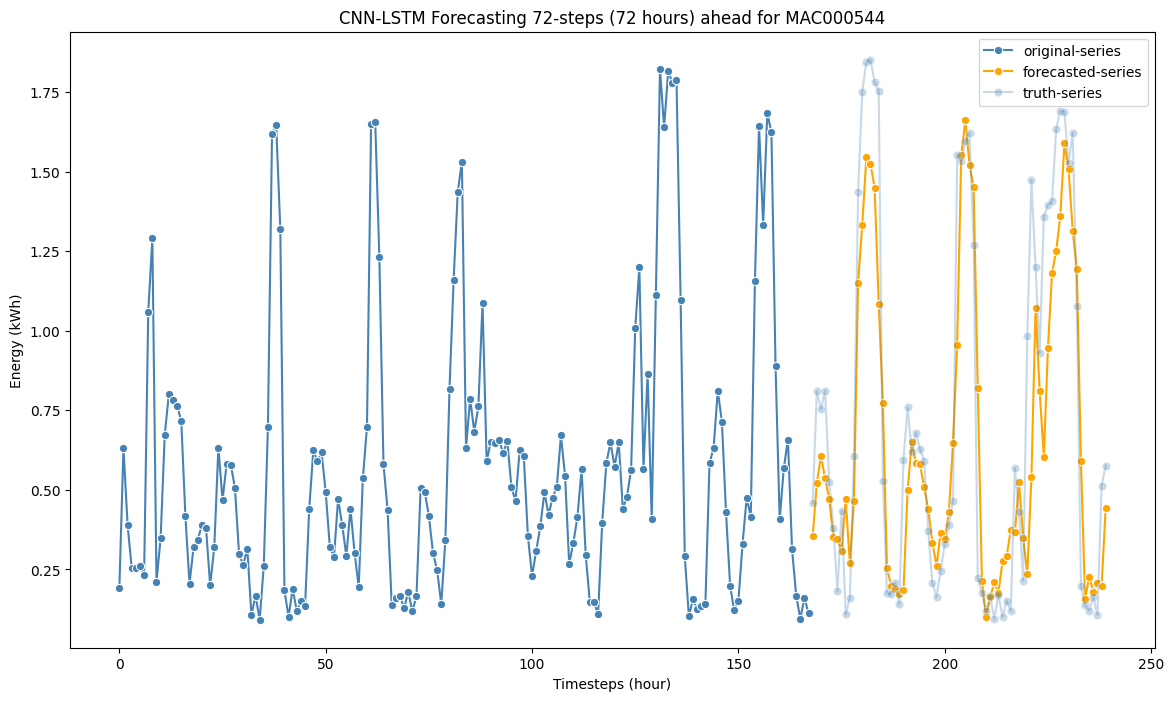

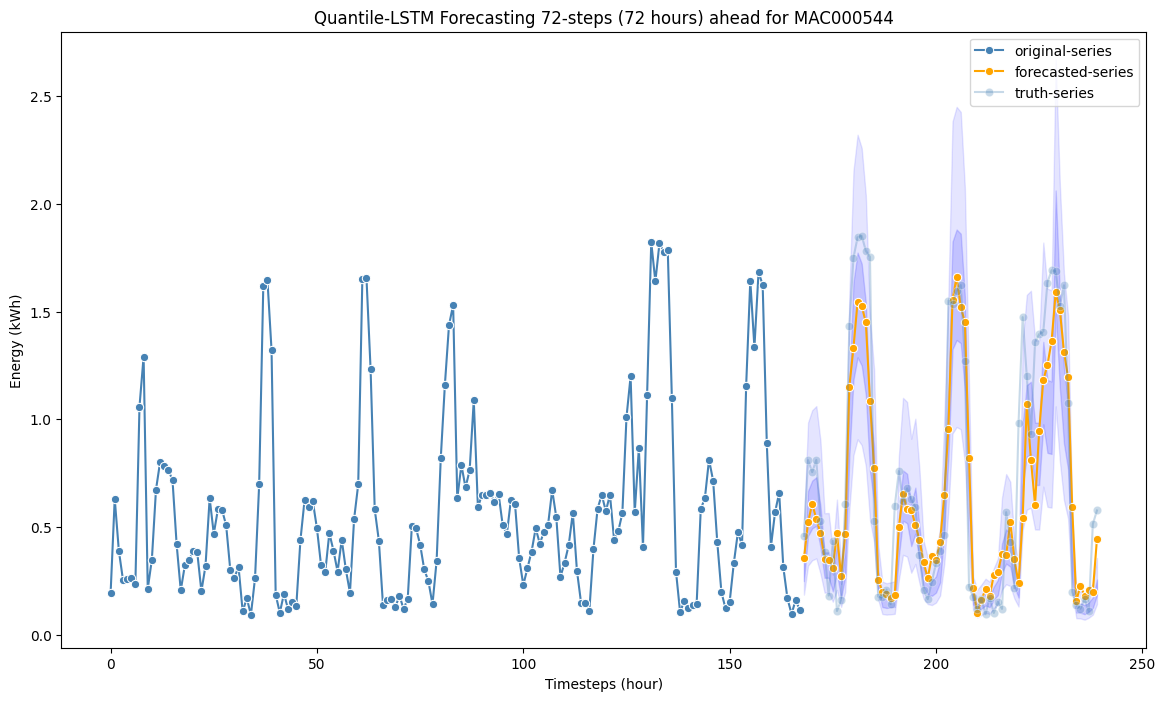

In [101]:
test_households = np.expand_dims(household_encoder.inverse_transform(test_household_ids), axis=1)
single_pred = np.expand_dims(lstm_pred.ravel(), axis=1)
formatted_quantile_pred = np.array(quantile_pred).squeeze()
formatted_quantile_pred = np.swapaxes(formatted_quantile_pred, 0, 1) # reverse the 1st and 2nd axis
test = np.expand_dims(y_test.to_numpy(), axis=1)
test_integrated = np.hstack((test_households, test, single_pred, formatted_quantile_pred))
test_integrated = pd.DataFrame(test_integrated, columns=['household_ids', 'y_test', 'y_pred', 'y_pred_0.1', 'y_pred_0.3', 'y_pred_0.5', 'y_pred_0.7', 'y_pred_0.9'])

train_households = np.expand_dims(household_encoder.inverse_transform(train_household_ids), axis=1)
train = np.expand_dims(y_train.to_numpy(), axis=1)
train_integrated = np.hstack((train_households, train))
train_integrated = pd.DataFrame(train_integrated, columns=['household_ids', 'y_train'])

selected_household_id = 'MAC000544'

# filter the data by household
filtered_train = train_integrated.loc[train_integrated['household_ids'] == selected_household_id]
filtered_train = filtered_train.iloc[-168:, :]
filtered_test = test_integrated.loc[test_integrated['household_ids'] == selected_household_id]
filtered_test = filtered_test.iloc[:72, :]
filtered_test = filtered_test[['y_test', 'y_pred', 'y_pred_0.1', 'y_pred_0.3',
       'y_pred_0.5', 'y_pred_0.7', 'y_pred_0.9']].astype('float32')
train_timesteps = np.arange(len(filtered_train))
max_train_timesteps = np.max(train_timesteps)
test_timesteps = np.arange(max_train_timesteps + 1, max_train_timesteps + 1 + 72)

plt.figure(figsize=(14, 8))
plt.title(f"CNN-LSTM Forecasting 72-steps (72 hours) ahead for {selected_household_id}")
sns.lineplot(x=train_timesteps, y=filtered_train['y_train'], label='original-series', marker='o', color='steelblue')
sns.lineplot(x=test_timesteps, y=filtered_test['y_pred'], label='forecasted-series', marker='o', color='orange')
sns.lineplot(x=test_timesteps, y=filtered_test['y_test'], label='truth-series', marker='o', color='steelblue', alpha=0.3)
plt.ylabel("Energy (kWh)")
plt.xlabel("Timesteps (hour)")
plt.show()


plt.figure(figsize=(14, 8))
plt.title(f"Quantile-LSTM Forecasting 72-steps (72 hours) ahead for {selected_household_id}")
sns.lineplot(x=train_timesteps, y=filtered_train['y_train'], label='original-series', marker='o', color='steelblue')
sns.lineplot(x=test_timesteps, y=filtered_test['y_pred'], label='forecasted-series', marker='o', color='orange')
sns.lineplot(x=test_timesteps, y=filtered_test['y_test'], label='truth-series', marker='o', color='steelblue', alpha=0.3)
plt.fill_between(x=test_timesteps, y1=filtered_test['y_pred_0.1'], y2=filtered_test['y_pred_0.9'], alpha=0.1, color='blue', label="10th-90th")
plt.fill_between(x=test_timesteps, y1=filtered_test['y_pred_0.3'], y2=filtered_test['y_pred_0.7'], alpha=0.15, color='blue', label="30th-70th")
plt.ylabel("Energy (kWh)")
plt.xlabel("Timesteps (hour)")
plt.show()
